# Information that matters
The goal of this notebook is to highlight any notable changes in a stock's option data 

In [246]:
# Load in dep 
import pandas as pd 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from IPython.display import display
%matplotlib inline

Load in the relevant data. 
Lets also include up to date stock price data as well

In [255]:
from glob import glob 
stocks = [str(x).split('/')[1] for x in glob('data/*')]

def get_n_data(symbol, n = 3,cumulative=True):
    """Gets the last n TRADING days data and returns the concatenated data frame'"""
    import datetime as dt
    import pandas as pd 
    from glob import glob 
    fnames = sorted(glob(f'data/{symbol}/OptionChain*'), reverse=False)

    if n> len(fnames):
        fnames = fnames
    else: 
        fnames = [fnames[-i] for i in range(1, (n+1))]

    dframes = []
    for i in fnames: 
        #scrapes the date from the file name
        date_recorded = str(i).split('_')[-1].split('.')[0]
        df =pd.read_csv(i)
        if 'cash' in df:
            del df['cash']
            del df['vol/oi']
            del df['mid']
            del df ['inTheMoney']
            del df['lastTradeDate']
            del df['change']
        df.insert(0, 'gatherDate', date_recorded)
        df.insert(0, 'stock', symbol)
        if 'expiry' in df:
            #df['dayToExp'] = np.datetime64(df['expiry']) - df.gatherDate
            df['timeValue'] = (pd.to_datetime(df['expiry']) - pd.to_datetime(df['gatherDate']))/ np.timedelta64(1,'D')/252
            #df['percentChange'] = df['percentChange']/100
            from datetime import datetime as dt 
            #df = df[df['expiry']> dt.today().strftime('%Y-%m-%d')]
            dframes.append(df)
        
    out = pd.concat([df for df in dframes])
    out  = out.set_index('gatherDate').sort_index()
    if cumulative == True:
        return out.loc[:,~out.columns.str.startswith('U')]
    else: 
        return dframes[-1].loc[:,~out.columns.str.startswith('U')]



def make_tweet(output, n=250):
    assert type(output) == list
    """ Make tweets from  a list of sentances that you wanted to split """
    lot = [(len(i),i) for i in output] # list of tuples (length, txt)
    out = [] # store tweets
    y=0 # count len of tweets
    t= '' # empty tweet 
    for l, txt in lot: # iterate over the list of tuples 
        y += l # add the length of the tweet after adding the new text
        t += txt # add the tweet's text
        if y >= 275: # if the length of the tweet exceed 275 delete that 
            t= '' # change the text to exmpty 
            y = 0 # change the length back to 0
        else:
            if y>= n:    
                out.append(t) 

    return out 



#### Gather the daily OHLCV data for each stock, Stored in one dataframe

In [248]:
def get_price_data(stocks, download = False):
    if download != False: 
        import yfinance as yf 
        from datetime import datetime as dt 
        today = dt.today().strftime('%Y-%m-%d')
        stock_price = yf.download(stocks, start='2021-09-01')
        stock_price.columns.names =['Metric', 'Stock_name']
        stock_price.head()
        stock_price.to_csv('stock_prices.csv')
        return stock_price
    else: 
        sp = pd.read_csv('stock_prices.csv', header=[0,1])
        sp.set_index(sp.columns[0], inplace= True)
        sp.index.name = 'Date'
        sp.columns.names =['Metric', 'Stock_name']
        return  sp.iloc[1:, :]
# store stock price in data frame so that you dont have to continuously load the same file in iteration
sp = get_price_data(stocks, True)

# get ohlcv for a prticular symbol 
def add_stock_price(stock, sp = sp):
    out = sp.xs(key = stock.upper(), axis = 1, level = 'Stock_name', drop_level=True)
    out.columns.names = ['']
    out.columns = out.columns.get_level_values(0)
    return out

add_stock_price('spy').tail()

[*********************100%***********************]  119 of 119 completed


,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2022-05-19,389.459991,389.459991,394.140015,387.109985,388.619995,98510700
2022-05-20,389.630005,389.630005,397.029999,380.540009,393.250000,131209600
2022-05-23,396.920013,396.920013,397.730011,390.380005,392.829987,76414900
2022-05-24,393.890015,393.890015,395.149994,386.959991,392.559998,91290000
2022-05-25,395.250000,395.250000,397.440002,391.920013,392.309998,28650592


### Store all of the data in a dictionary, with option data and price data as different keys

In [249]:
stock_data = {x:{'option_data': get_n_data(x, 93, cumulative=True), 'price_data': add_stock_price(x)} for x in stocks}
display(stock_data['spy']['option_data'].head())

,stock,contractSymbol,strike,lastPrice,bid,ask,percentChange,volume,openInterest,impliedVolatility,type,expiry,stk_price,timeValue
gatherDate,,,,,,,,,,,,,,
2022-01-12,spy,SPY241220P00720000,720.0,250.92,248.50,253.50,2.18,1.0,2.0,0.161111,Put,2024-12-20,471.02,4.257937
2022-01-12,spy,SPY220209C00464000,464.0,11.83,12.01,12.15,1.81,11.0,122.0,0.156747,Call,2022-02-09,471.02,0.111111
2022-01-12,spy,SPY220209C00465000,465.0,11.64,11.28,11.42,7.28,32.0,68.0,0.154427,Call,2022-02-09,471.02,0.111111
2022-01-12,spy,SPY220209C00466000,466.0,10.63,10.56,10.66,5.77,501.0,116.0,0.151254,Call,2022-02-09,471.02,0.111111
2022-01-12,spy,SPY220209C00468000,468.0,10.01,9.11,9.27,11.22,50.0,131.0,0.146432,Call,2022-02-09,471.02,0.111111


In [250]:
display(stock_data['spy']['price_data'].tail())

,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2022-05-19,389.459991,389.459991,394.140015,387.109985,388.619995,98510700
2022-05-20,389.630005,389.630005,397.029999,380.540009,393.250000,131209600
2022-05-23,396.920013,396.920013,397.730011,390.380005,392.829987,76414900
2022-05-24,393.890015,393.890015,395.149994,386.959991,392.559998,91290000
2022-05-25,395.250000,395.250000,397.440002,391.920013,392.309998,28650592


# iterating through this dictionary
printing a few stocks and the length of the options data gathered. 

In [251]:
out = []
for stock, item in stock_data.items(): 
    out.append((stock, len(item['option_data']), len(item['price_data'])))
print(out[:10])

[('gme', 71252, 185), ('amzn', 407536, 185), ('spy', 692366, 185), ('xlf', 85338, 185), ('aapl', 164099, 185), ('pfe', 65157, 185), ('aal', 67360, 185), ('uber', 65865, 185), ('uup', 20263, 185), ('pep', 12873, 185)]


# Lets do some analysis on the cumulative data. 

Relative calculations: we can confirm if a stock is in a buying or selling phase if the relative volume is noticably lower or higher than the historical counter part. Lets use the last 30 days of data to calculate this metric on the option data, however on the stock price data we can get a deeper look because we have more data availible. We can calculate the relative volume as follows: $$ \text{RelativeVolume} = \frac{\text{Volume}}{\text{AvgVolume}}$$

In [252]:
for stock, item in stock_data.items(): 
    df = item['price_data'].copy()
    df['relative_volume'] = df.Volume / df['Volume'].iloc[:-1].mean()
    item['price_data'] = df

display(stock_data['csco']['price_data'].head())
display(stock_data['spy']['option_data'].head())

,Adj Close,Close,High,Low,Open,Volume,relative_volume
Date,,,,,,,
2021-09-01,57.903759,59.040001,59.139999,58.660000,59.020000,11629700,0.543642
2021-09-02,58.384327,59.529999,59.720001,59.060001,59.349998,12855700,0.600953
2021-09-03,58.276443,59.419998,59.660000,59.279999,59.330002,9732200,0.454942
2021-09-07,57.746841,58.880001,59.369999,58.750000,59.240002,15503600,0.724732
2021-09-08,57.550690,58.680000,58.930000,58.490002,58.549999,13124500,0.613518


,stock,contractSymbol,strike,lastPrice,bid,ask,percentChange,volume,openInterest,impliedVolatility,type,expiry,stk_price,timeValue
gatherDate,,,,,,,,,,,,,,
2022-01-12,spy,SPY241220P00720000,720.0,250.92,248.50,253.50,2.18,1.0,2.0,0.161111,Put,2024-12-20,471.02,4.257937
2022-01-12,spy,SPY220209C00464000,464.0,11.83,12.01,12.15,1.81,11.0,122.0,0.156747,Call,2022-02-09,471.02,0.111111
2022-01-12,spy,SPY220209C00465000,465.0,11.64,11.28,11.42,7.28,32.0,68.0,0.154427,Call,2022-02-09,471.02,0.111111
2022-01-12,spy,SPY220209C00466000,466.0,10.63,10.56,10.66,5.77,501.0,116.0,0.151254,Call,2022-02-09,471.02,0.111111
2022-01-12,spy,SPY220209C00468000,468.0,10.01,9.11,9.27,11.22,50.0,131.0,0.146432,Call,2022-02-09,471.02,0.111111


#### Now lets find some of the highest relative volume in the past week: 

In [264]:
n_periods = 10
high_relative_volume = []
for stock, item in stock_data.items():
    rv = item['price_data']['relative_volume'].rolling(n_periods).mean().iloc[-1]
    if rv > 2:
        high_relative_volume.append((stock, rv, n_periods))



high_relative_volume = sorted(high_relative_volume, key = lambda x: x[1], reverse=True)
print("Stocks trading @ ≥ 2x Daily average Volume:")
for x in high_relative_volume: print(f'${x[0].upper()}: {x[1]:.2f}x Relative Volume') 


Stocks trading @ ≥ 2x Daily average Volume:
$COIN: 3.32x Relative Volume
$TGT: 3.01x Relative Volume
$WEAT: 2.97x Relative Volume
$RBLX: 2.21x Relative Volume
$SNAP: 2.19x Relative Volume
$UUP: 2.12x Relative Volume
$AFRM: 2.03x Relative Volume


### Now on to the options data volume
This one wont be as clear as above, however it is very iterative. We need to perform the same operations on the call and put volumes, as well as get an overview by taking the sum of both. 

In [ ]:
df = stock_data['tlt']['option_data']
df = df.groupby(['gatherDate', 'type'])[['volume', 'openInterest']].sum().reset_index()
#cast(df.drop('openInterest', axis = 1), 'type', 'volume').merge(cast(df.drop('volume', axis = 1), 'type', 'openInterest'), on=['gatherDate'])
if 'Put' in list(df['type']):
    print('hi')


hi


In [ ]:

from dataFunctions_2 import cast 
rolling_window = 2
min_n = 1
for stock, item in stock_data.items(): 
    df = item['option_data'].reset_index().copy()
    df = df.groupby(['gatherDate', 'type'])[['volume', 'openInterest']].sum().reset_index()
    df = cast(df.drop('openInterest', axis = 1), 'type', 'volume').merge(cast(df.drop('volume', axis = 1), 'type', 'openInterest'), on=['gatherDate'])
    df['total_volume'] = df['Call_volume'] + df['Put_volume']
    df['total_openInterest'] = df['Call_openInterest'] + df['Put_openInterest']
    df['relative_volume'] = df['total_volume'] / df['total_volume'].rolling(rolling_window, min_periods = min_n).mean()
    df['relative_openInterest'] = df['total_openInterest'] / df['total_openInterest'].rolling(rolling_window, min_periods = min_n).mean()
    df['relative_Call_volume'] = df['Call_volume'] / df['Call_volume'].rolling(rolling_window, min_periods = min_n).mean()
    df['relative_Put_volume'] = df['Put_volume'] / df['Put_volume'].rolling(rolling_window, min_periods = min_n).mean()
    df['relative_Call_openInterest'] = df['Call_openInterest'] / df['Call_openInterest'].rolling(rolling_window, min_periods = min_n).mean()
    df['relative_Put_openInterest'] = df['Put_openInterest'] / df['Put_openInterest'].rolling(rolling_window, min_periods = min_n).mean() 
    calls = df[['gatherDate','Call_volume', 'relative_Call_volume', 'Call_openInterest', 'relative_Call_openInterest']]
    puts = df[['gatherDate','Put_volume', 'relative_Put_volume', 'Put_openInterest', 'relative_Put_openInterest']]
    total_volume = df[['gatherDate','total_volume', 'relative_volume', 'total_openInterest','relative_openInterest']]
    calls.columns = ['gatherDate', 'volume', 'relative_volume', 'openInterest', 'relative_openInterest']
    puts.columns = ['gatherDate', 'volume', 'relative_volume', 'openInterest', 'relative_openInterest']
    total_volume.columns = ['gatherDate', 'volume', 'relative_volume', 'openInterest', 'relative_openInterest']
    item['option_volume'] = {'total_option_volume': total_volume.set_index('gatherDate'), 'calls': calls.set_index('gatherDate'), 'puts': puts.set_index('gatherDate')}

#stock_data['spy']['option_volume']['total_option_volume'].tail()

In [ ]:
symb, otype = 'aapl', 'calls'
stock_data[symb]['option_volume'][otype].merge(stock_data[symb]['price_data']['Close'], left_index = True, right_index = True)

,volume,relative_volume,openInterest,relative_openInterest,Close
2022-01-11,684074.0,1.000000,4670655.0,1.000000,175.080002
2022-01-12,717487.0,1.023840,4739448.0,1.007311,175.529999
2022-01-13,590071.0,0.902554,4795551.0,1.005884,172.190002
2022-01-14,465850.0,0.882358,4844270.0,1.005054,173.070007
2022-01-18,582603.0,1.111357,4615667.0,0.975835,169.800003
...,...,...,...,...,...
2022-05-17,546140.0,0.971785,4191714.0,1.009940,149.240005
2022-05-18,613118.0,1.057777,4255924.0,1.007601,140.820007
2022-05-19,995333.0,1.237629,4369658.0,1.013186,137.350006
2022-05-20,883756.0,0.940622,4563598.0,1.021710,137.589996


In [ ]:

def pdata(symb, n, otype):
    tmp_df = stock_data[symb]['option_volume'][otype].merge(stock_data[symb]['price_data']['Close'], left_index = True, right_index = True)
    tmp_df = tmp_df[['relative_volume', 'relative_openInterest', 'Close']].copy()
    tmp_df = tmp_df.rolling(n).mean().dropna()
    tmp_df.index = pd.to_datetime(tmp_df.index)
    return tmp_df

tmp_df = pdata('wmt', 10, 'total_option_volume')
import pandas as pd



In [ ]:
def plot_relative_volume(symbol, n = 28):
    calls = pdata(symbol, n, 'calls')
    puts = pdata(symbol, n, 'puts')

    #plt.style.use('dark_background')
    plt.style.use('classic')
    fig, (axes, axes2) = plt.subplots(1,  2,figsize = (25, 8))
    ax2 = axes.twinx() 
    ax3 = axes2.twinx() 

    ax2.plot(calls.index, calls['Close'].pct_change(), label = 'Scaled Stock Price', color = 'black', alpha = 0.2)
    ax3.plot(puts.index, puts['Close'].pct_change  (), label = 'Scaled Stock Price', color = 'black', alpha = 0.2)

    axes.plot(calls.index, calls['relative_volume'], label = 'R.Volume', color = 'green')
    axes.plot(calls.index, calls['relative_openInterest'], label = 'R.OpenInterest', color = 'blue')
    axes2.plot(puts.index, puts['relative_volume'], label = 'R.Volume', color = 'red')
    axes2.plot(puts.index, puts['relative_openInterest'], label = 'R.OpenInterest', color = 'blue')


    axes.set_title('Calls')
    axes2.set_title('Puts')

    import matplotlib.dates as mdates
    for i in [axes, axes2]:
        #i.xaxis.set_major_locator(mdates.DayLocator(interval = 10))
        #i.xaxis.set_minor_locator(mdates.DayLocator())
        #i.xaxis.set_major_formatter( mdates.ConciseDateFormatter( axes.xaxis.get_minor_formatter() ))
        i.legend(prop={'size': 10})
    fig.autofmt_xdate(rotation=45)
    plt.show()

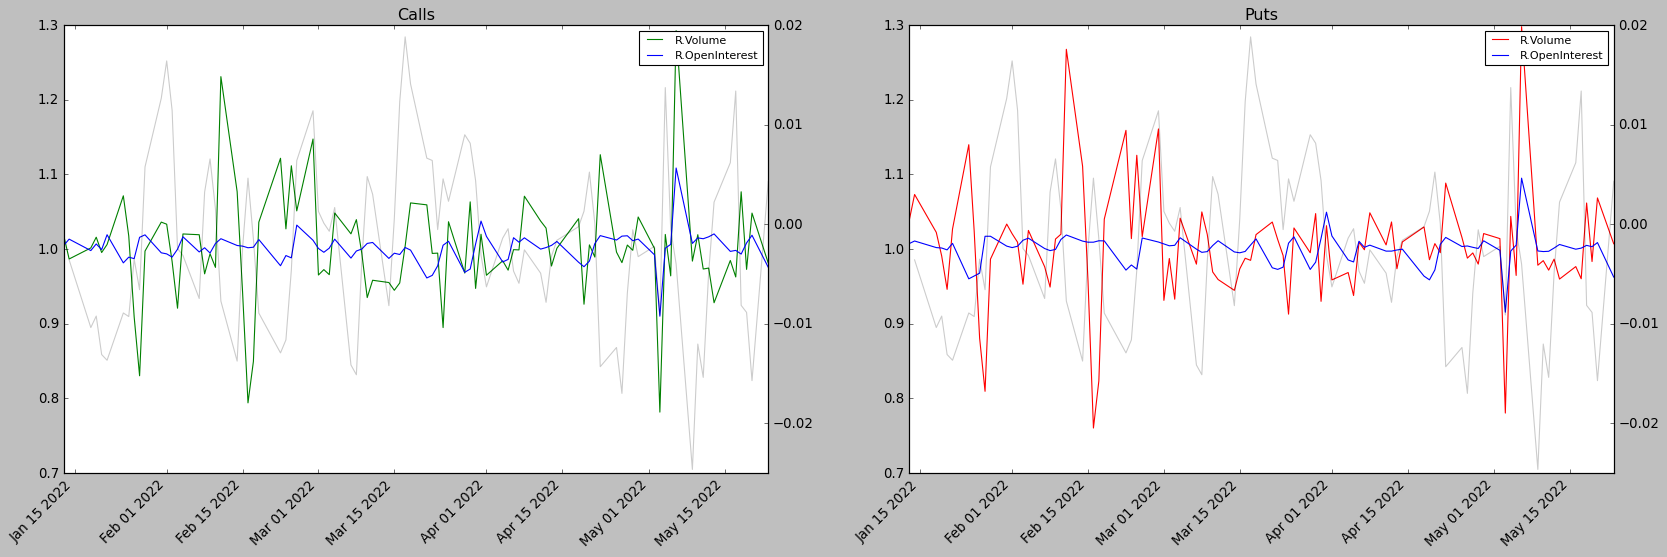

In [ ]:
plot_relative_volume('spy', 3)

In [ ]:
stock_data['spy'].keys()

dict_keys(['option_data', 'price_data', 'option_volume'])

## Relative Call and Put volumes 

The calculation for releative volume is $\frac{Volume}{Avg.Volume}$

Call to put ratio: The ratio of The relative call volume compared to the relative put volume. 




In [ ]:
for stock, item in stock_data.items():
    if 'option_volume' in item.keys():
        rt = item['option_volume']['total_option_volume']['relative_volume'].iloc[-1]
        rc = item['option_volume']['calls']['relative_volume'].iloc[-1]
        rp = item['option_volume']['puts']['relative_volume'].iloc[-1]
        if abs(rc - rp) >= .5:
            print(f'${stock.upper()} daily relative CALL volume is {rc:.2f} relative PUT volume is {rp:.2f}')
            print('----'*17)


$LC daily relative CALL volume is 0.99 relative PUT volume is 0.23
--------------------------------------------------------------------
$XLV daily relative CALL volume is 0.17 relative PUT volume is 0.91
--------------------------------------------------------------------
$ICLN daily relative CALL volume is 1.56 relative PUT volume is 0.95
--------------------------------------------------------------------
$CTRA daily relative CALL volume is 1.85 relative PUT volume is 1.22
--------------------------------------------------------------------
$GLD daily relative CALL volume is 1.14 relative PUT volume is 0.37
--------------------------------------------------------------------
$CLX daily relative CALL volume is 1.79 relative PUT volume is 1.05
--------------------------------------------------------------------


In [ ]:
n = 2
for stock, item in stock_data.items():
    if 'option_volume' in item.keys():
        rt = item['option_volume']['total_option_volume']['relative_volume'].rolling(n).mean().iloc[-1]
        rc = item['option_volume']['calls']['relative_volume'].rolling(n).mean().iloc[-1]
        rp = item['option_volume']['puts']['relative_volume'].rolling(n).mean().iloc[-1]
        if (rp/rt) <= .9:
            print(f'${stock.upper()} daily relative CALL/PUT volume is {(rc/rp):.2f} \tPercentages Call|Put ({rc/rt:.2f}|{rp/rt:.2f})')


$HD daily relative CALL/PUT volume is 1.18 	Percentages Call|Put (1.05|0.89)
$ABBV daily relative CALL/PUT volume is 1.54 	Percentages Call|Put (1.17|0.76)
$XLE daily relative CALL/PUT volume is 1.28 	Percentages Call|Put (1.13|0.88)
$CLSK daily relative CALL/PUT volume is 1.18 	Percentages Call|Put (1.05|0.89)
$ASAN daily relative CALL/PUT volume is 1.43 	Percentages Call|Put (1.26|0.88)
$RTX daily relative CALL/PUT volume is 1.20 	Percentages Call|Put (1.08|0.90)
$CTVA daily relative CALL/PUT volume is 1.35 	Percentages Call|Put (1.10|0.82)
$CTRA daily relative CALL/PUT volume is 1.24 	Percentages Call|Put (1.04|0.84)
$TBT daily relative CALL/PUT volume is 1.27 	Percentages Call|Put (1.07|0.84)
$C daily relative CALL/PUT volume is 1.36 	Percentages Call|Put (1.14|0.84)
$GLD daily relative CALL/PUT volume is 1.68 	Percentages Call|Put (1.12|0.66)
$CLX daily relative CALL/PUT volume is 1.53 	Percentages Call|Put (1.09|0.71)
$JPM daily relative CALL/PUT volume is 1.21 	Percentages Call|

### Now we have an idea of the tickers that are trading above the average volume. Lets Look for options premiums that are trading lower than the average 
The only problem is that we wish to exclude those far in the money options which will usually have a high premium. 

In [ ]:
def describe_option(y):
    """Use regular expressions to determine strike, type, expiration, and underlying stock"""
    import re
    import datetime as dt 
    valid = re.compile(r'(?P<stock>[A-Z]+)(?P<expiry>[0-9]+)(?P<type>[C|P])00(?P<strike>[0-9]+)0')
    stock = valid.match(y).group('stock')
    expiration = dt.datetime.strptime(valid.match(y).group('expiry'), "%y%m%d")
    conttype = valid.match(y).group('type')
    strike = float(valid.match(y).group('strike'))/100
    return (stock, conttype, float(strike), expiration.strftime('%Y-%m-%d'))
print(describe_option('FCEL220527C00002500'))

('FCEL', 'C', 2.5, '2022-05-27')


In [ ]:
def gb_df(d):
    df = d[['contractSymbol', 'lastPrice', 'ask', 'bid', 'strike']].sort_index().copy()
    df = df[(df['lastPrice']>.05) & (df['lastPrice']<3.50) & ((df['ask'] - df['bid'])> .05)]
    

    assert 'contractSymbol' in d
    contracts = df['contractSymbol'].unique() #get unique contractSymbols 
    contract_df = df.reset_index().groupby('contractSymbol') # groupby contracts (todays price)
    out = pd.DataFrame(columns = ['contract', 'average', 'last'])

    for i in range(len(contracts)):
        cont_df = contract_df.get_group(contracts[i])['lastPrice']
        if len(cont_df) > 3:
            out.loc[i, 'contract'] = contracts[i]
            out.loc[i, 'average'] = round(np.mean(cont_df.iloc[:-1]), 2)
            out.loc[i, 'last'] = cont_df.iloc[-1]
    
    out['discount'] = ((out['average'] > out['last'])) * 1
    return out.set_index('contract')

for stock, item in stock_data.items():     
    from dataFunctions_2 import cast
    lastPrice = item['price_data']['Close'].iloc[-1].round(2)
    option_df = item['option_data'].copy() #Load the options dataframe 
    calls = gb_df(option_df[option_df['type'] == "Call"]) #Seperate calls
    puts = gb_df(option_df[option_df['type'] == 'Put']) #Seperate puts
    item['prem_dif'] = {'all_contracts':calls.append(puts) ,'calls':calls, 'puts':puts}

stock_data['spy']['prem_dif']['puts'].head()

,average,last,discount
contract,,,
SPY221216P00260000,2.9,2.98,0
SPY221216P00255000,2.92,2.81,1
SPY221216P00125000,0.58,0.47,1
SPY221216P00130000,0.66,0.5,1
SPY221216P00135000,0.65,0.68,0


If the average price of a contract is greater than the last price of a contract, then we can say the contract is trading at a discount. And vice versa, If the average price of a contract is less than the last price of a contract, then we can say the contract is trading at a premium compared to the average values. 

Thus, when we see a 0 in the `diff` column of the `prem_dif` dataframe, this indicates that the average price is greater than the last price. 

0 = Option is trading at a premium 

1 = Option is trading at a discount 

In [ ]:
stock_data['aa']['prem_dif']['calls']['discount'].value_counts()

Series([], Name: discount, dtype: int64)

#### All of the contracts traded above or under the average price are stored in `df_out`
Sorting the `Discount_to_Prem_ratio` in decsending order shows the largest discount to premium ratio.

**Note** This data is relative for today, i wonder how it would look if we did this daily.. 

In [ ]:
def count_prem_discount(d):
    #d_map = {'0': 'Premium', '1': 'Discount'}
    counts = d['discount'].value_counts()
    if len(counts) == 1:
        if counts.index.item() == 0:
             return 0, d['discount'].value_counts()[0]
        if counts.index.item() == 1:
           return d['discount'].value_counts()[1], 0
    else:
        return d['discount'].value_counts()

skips = ['aa', 'x']
df_out = pd.DataFrame(columns = ['Discount', 'Premium'])
for stock, item in stock_data.items():
    if stock not in skips: 
        discount, prem = count_prem_discount(item['prem_dif']['puts'])
        if discount > prem:
            df_out.loc[stock.upper(), 'Discount'] = discount
            df_out.loc[stock.upper(), 'Premium'] = prem

df_out['Discount_to_Prem_ratio'] = df_out['Discount'].divide(df_out['Premium'])
display(df_out.sort_values('Discount_to_Prem_ratio', ascending= False).head(20))

,Discount,Premium,Discount_to_Prem_ratio
AMZN,1269,160,7.93125
AMC,135,24,5.625
GME,384,87,4.413793
TMV,149,36,4.138889
UNG,379,93,4.075269
SPOT,89,25,3.56
DIS,85,30,2.833333
JKS,70,26,2.692308
SNOW,320,120,2.666667
CLSK,29,11,2.636364


## Recap of the methods used above

So far, we have found the daily relative option volume for calls and puts, the stock price, and open interest. We can use this data to find stocks that have are trading with a relativley higher volume than normal. We can also see if that relativily higher volume can be seen further in the options market with the relative volume/ open interest for calls and puts. Next we investigated the price action of individual contracts, we looked at the average price over time and compared that to the last observed price. For contracts trading below the average price, we deemed those as trading at a discount. For those trading above the average price we deemed those as trading at a premium. 

In [ ]:
t = stock_data['spy']['prem_dif']['calls']
t['difference'] = t['average']-t['last']
t.sort_values('difference', ascending=False).head(20)

,average,last,discount,difference
contract,,,,
SPY221230C00518000,2.93,0.67,1,2.26
SPY230331C00540000,2.64,0.56,1,2.08
SPY220916C00507000,2.51,0.57,1,1.94
SPY220930C00504000,2.53,0.59,1,1.94
SPY220930C00498000,2.81,0.9,1,1.91
SPY220916C00512000,2.27,0.4,1,1.87
SPY220321C00461000,2.8,0.94,1,1.86
SPY221230C00530000,2.08,0.23,1,1.85
SPY220819C00495000,2.39,0.57,1,1.82


<AxesSubplot:xlabel='gatherDate'>

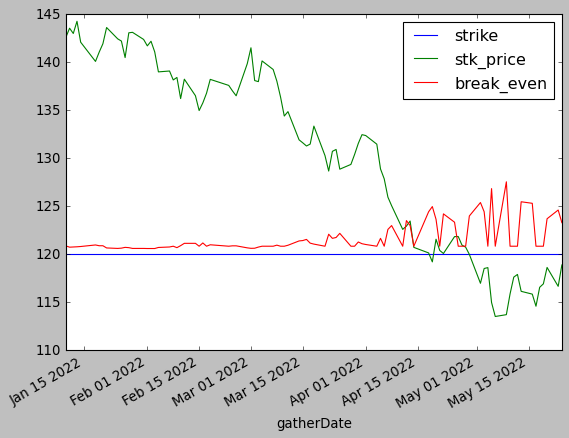

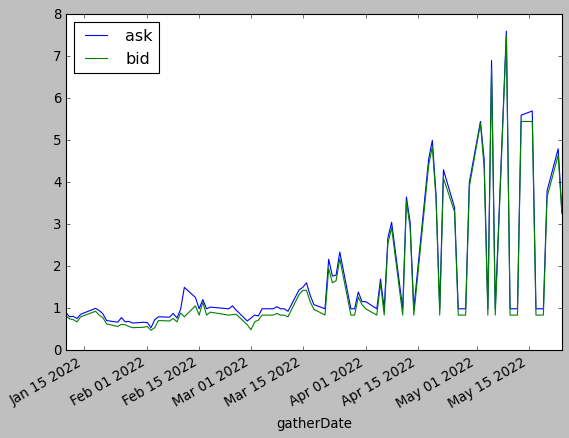

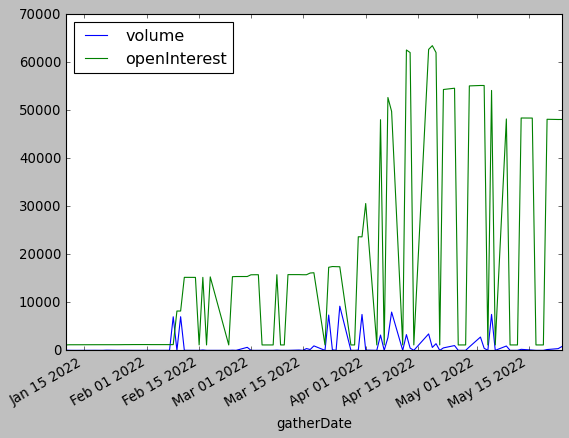

In [ ]:
call_put = 'TLT220617P00120000'
t = stock_data['tlt']['option_data'].copy()
t['break_even'] = t['strike'] + t['lastPrice']
t.index = pd.to_datetime(t.index) 
tmp = t[t['contractSymbol'] ==call_put ].sort_index()
tmp[[ 'strike', 'stk_price','break_even']].plot()
tmp[['ask', 'bid']].plot()
tmp[['volume', 'openInterest']].plot()

In [ ]:
(tmp['lastPrice']*100).tail(45)

gatherDate
2022-03-22    210.0
2022-03-23    167.0
2022-03-24    176.0
2022-03-25    219.0
2022-03-28     85.0
2022-03-29     85.0
2022-03-30    129.0
2022-03-31    111.0
2022-04-01    103.0
2022-04-04     85.0
2022-04-05    167.0
2022-04-06     85.0
2022-04-07    260.0
2022-04-08    300.0
2022-04-11     85.0
2022-04-12    352.0
2022-04-13    300.0
2022-04-14     85.0
2022-04-18    444.0
2022-04-19    498.0
2022-04-20    365.0
2022-04-21     85.0
2022-04-22    422.0
2022-04-25    335.0
2022-04-26     85.0
2022-04-27     85.0
2022-04-28     85.0
2022-04-29    400.0
2022-05-02    540.0
2022-05-03    444.0
2022-05-04     85.0
2022-05-05    685.0
2022-05-06     85.0
2022-05-09    756.0
2022-05-10     85.0
2022-05-11     85.0
2022-05-12     85.0
2022-05-13    548.0
2022-05-16    532.0
2022-05-17     85.0
2022-05-18     85.0
2022-05-19     85.0
2022-05-20    371.0
2022-05-23    462.0
2022-05-24    330.0
Name: lastPrice, dtype: float64